In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')
import cv2

import seaborn as sns

## Discriminator

In [135]:
class Conv2Central(nn.Module):
    def __init__(self):
        super().__init__()
        self.kernel  = Variable(torch.tensor([[[[1., 0.5],[0.5, 0.25]]]]))
    
    def forward(self, img):
        N, H, W = img.size()
        img0 = img.unsqueeze(1)
        
        img1 = torch.cat((torch.cat((img0, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img2 = F.conv2d(img1, self.kernel, stride=(1, 1))
        img3 = torch.flip(img2, dims=[0])
        
        img4 = torch.cat((torch.cat((img3, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img5 = F.conv2d(img4, self.kernel, stride=(1, 1))
        img6 = torch.flip(img5, dims=[1])
        
        img7 = torch.cat((torch.cat((img6, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img8 = F.conv2d(img7, self.kernel, stride=(1, 1))
        img9 = torch.flip(img8, dims=[0])
        
        img10 = torch.cat((torch.cat((img9, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img11 = F.conv2d(img10, self.kernel, stride=(1, 1))
        img12 = torch.flip(img11, dims=[1])
        
        img13 = img12.squeeze(1)
        return img13

In [9]:
class RoundNoGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.round()
    @staticmethod
    def backward(ctx, g):
        return g

In [6]:
class Num2Point(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.fc1 = nn.Linear(1, n*2)
        self.fc2 = nn.Linear(n*2, n)
        self.fc3 = nn.Linear(n, n)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(-1, 1) # Linear層に入力できるようにサイズを(batch_size, C)にする
        x = self.sigmoid(self.fc1(x)) # write me! # fc1 + sigmoid
        x = self.sigmoid(self.fc2(x)) # write me! # fc2 + sigmoid
        y = self.fc3(x) # write me! # fc3
        return y

In [7]:
class PlotLine(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        #self.conv2central = Conv2Central()
        self.num2point = Num2Point(img_size)
        self.num2point.load_state_dict(torch.load('params.pth', map_location=torch.device('cpu') ))
        # freeze all layers
        for param in self.num2point.parameters():
            param.requires_grad = False
        

    def forward(self, points):
        N = points.size()[0] # batch_size
        
        points0 = torch.cat((torch.zeros([N,1,2]),
                            points.repeat([1,1,2]).reshape([N,-1, 2]),
                            torch.zeros([N,1,2])), dim=1).reshape([N, -1, 2, 2])[:, 1:-1]
        #print(points0)
        t = torch.tensor(range(0, self.img_size+1))/self.img_size
        ts = torch.stack((1-t, t)).to(torch.float)
        line = torch.matmul(ts.mT, points0)
        #print(line)
        #line = torch.round(line)
        line0 = RoundNoGradient.apply(line)
        #line0 = line
        #print(line0)
        line1 = line0[:, :, 0:-1].reshape(N, -1, 2)
        #print(line1)
        shape = line1.size()
        line2 = line1.flatten()
#         E = Variable(torch.eye(self.img_size), requires_grad=True) # ここからline４までDNNで作るしかないか？
#         #line = F.embedding(line.to(torch.long), E)
#         line3 = ToLongNoGradient.apply(line2)
#         print(line3)
#         #line3 = line2
#         line4 = F.embedding(line3, E)
        line4 = F.softmax(self.num2point(line2), dim=1)
        #print(line4)
        line5 = line4.reshape(*shape, -1)
        x = line5[:, :, 0, :].unsqueeze(2)
        y = line5[:, :, 1, :].unsqueeze(2)
        p_map = torch.matmul(x.mT, y).sum(dim=1)
        #p_map0 = self.conv2central(p_map)
        p_map0 = torch.tanh(p_map*3)
        return p_map0

tensor([[32., 39.],
        [29., 19.],
        [12., 17.],
        [20., 20.],
        [41., 35.]])


<AxesSubplot:>

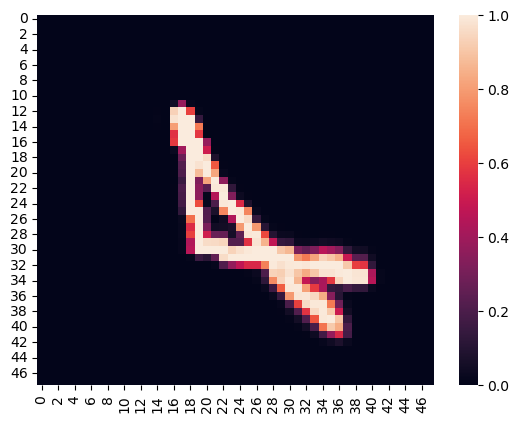

In [229]:
points = torch.randint(0, 48, [5, 2]).to(torch.float)
print(points)
# points = torch.tensor([[ 0.,  0.,  0., 47.,  0., 47.,  0.,  0.,  0., 47.],
#                                         [ 0., 47.,  0., 47.,  0.,  0., 47.,  0., 47.,  0.]])

plot_line = PlotLine(48)
inputs = Variable(points.unsqueeze(0), requires_grad=True)
canvas = plot_line(inputs)
sns.heatmap(canvas.detach().numpy()[0])

In [46]:
(torch.diff(points, dim=-2)**2).sum()

tensor(2355.)

In [18]:
xs = torch.tensor(range(0, 48)).to(torch.float).reshape(-1, 1)
#xs
#test = num2point(inputs)

tensor([1.0000e+00, 3.6788e-01, 1.8316e-02, 1.2341e-04, 1.1254e-07, 1.3888e-11,
        2.3195e-16, 5.2429e-22, 1.6038e-28, 6.6397e-36, 3.7835e-44, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])


<AxesSubplot:>

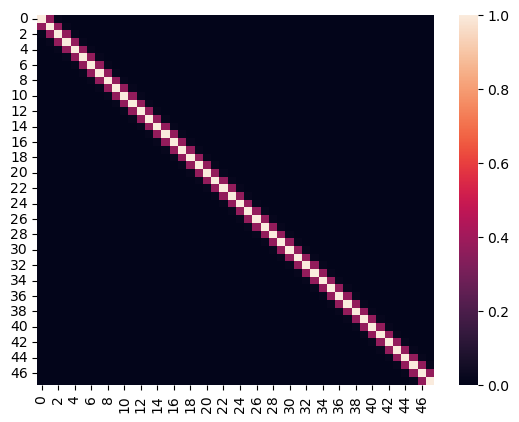

In [230]:
cs = torch.tensor(range(0, 48)).to(torch.float)
ys = torch.exp(-(xs - cs)**2)
#ys = torch.softmax(-5*(xs - cs)**2, dim=1)
print(ys[0])
sns.heatmap(ys)

In [99]:
def process_img(img):
    img_np = np.array(img)
    img_np = ~img_np
    _, img_th = cv2.threshold(img_np, 0, 1, cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.float32)/9.
    img_blr = cv2.filter2D(img_th.astype(np.float32),-1,kernel)
    #img_blr = img_blr.squeeze()
    return img_blr

In [216]:
class Discriminator(nn.Module):
    def __init__(self, img):
        super().__init__()
        self.img_size = len(img)
        self.img = torch.from_numpy(process_img(img)).clone().unsqueeze(0)
        
        self.plot_line = PlotLine(self.img_size)
        #self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        self.p_map = None
        
    def forward(self, points):
        x = self.plot_line(points)
        self.p_map = x
        t = self.img
        #loss = torch.sum(x*self.img)
        #loss = self.criterion(x, self.img)
        loss = ((x - t)**2).sum()
        return loss

In [217]:
disc = Discriminator(img_array)
points = torch.randint(0, 48, [5, 2]).to(torch.float)
inputs = Variable(points.unsqueeze(0), requires_grad=True)
loss = disc(inputs)
loss

tensor(305.6585, grad_fn=<SumBackward0>)

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, img_size, n_point):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        hidden_size1 = input_size//4
        hidden_size2 = 2*img_size
        output_size = 2*n_point
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=False)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=False)
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, img):
        x = self.flatten(img)
        #x = x.view(-1, 1) # Linear層に入力できるようにサイズを(batch_size, C)にする. --> x = nn.Flatten(img)
        x = self.sigmoid(self.fc1(x)) # write me! # fc1 + sigmoid
        x = self.sigmoid(self.fc2(x)) # write me! # fc2 + sigmoid
        y = self.fc3(x) # write me! # fc3
        y_num = torch.sigmoid(y)*float(self.img_size - 1.0)
        out = y_num.reshape(-1, self.n_point, 2)
        return out

In [251]:
i = torch.ones(3,48,48)
flatten = nn.Flatten()
# nn.Flatten(i)
flatten(i).size()

torch.Size([3, 2304])

In [254]:
i = Variable(torch.ones(1,48,48), requires_grad=True)

gen = Generator(n_point=20, img_size=48)
test = gen(i).sum()
test.backward()
print(gen.fc1.weight.grad)
print(i.grad)

tensor([[ 0.0411,  0.0411,  0.0411,  ...,  0.0411,  0.0411,  0.0411],
        [-0.0374, -0.0374, -0.0374,  ..., -0.0374, -0.0374, -0.0374],
        [-0.0036, -0.0036, -0.0036,  ..., -0.0036, -0.0036, -0.0036],
        ...,
        [ 0.0956,  0.0956,  0.0956,  ...,  0.0956,  0.0956,  0.0956],
        [ 0.0235,  0.0235,  0.0235,  ...,  0.0235,  0.0235,  0.0235],
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027]])
tensor([[[ 0.0312, -0.0134, -0.0108,  ...,  0.0488,  0.0136, -0.0371],
         [-0.0004,  0.0057,  0.0022,  ..., -0.0070, -0.0054,  0.0201],
         [-0.0133,  0.0035, -0.0307,  ..., -0.0249, -0.0022,  0.0063],
         ...,
         [ 0.0232,  0.0053, -0.0160,  ...,  0.0301, -0.0174,  0.0096],
         [ 0.0071, -0.0176,  0.0225,  ...,  0.0194, -0.0148,  0.0156],
         [ 0.0144, -0.0091, -0.0074,  ...,  0.0050,  0.0122, -0.0004]]])


## ひらがなデータ

[[202 202 202 ... 206 205 204]
 [201 201 202 ... 206 205 204]
 [200 200 201 ... 206 204 203]
 ...
 [200 201 204 ... 203 201 201]
 [203 202 203 ... 203 202 201]
 [206 203 202 ... 203 203 203]]


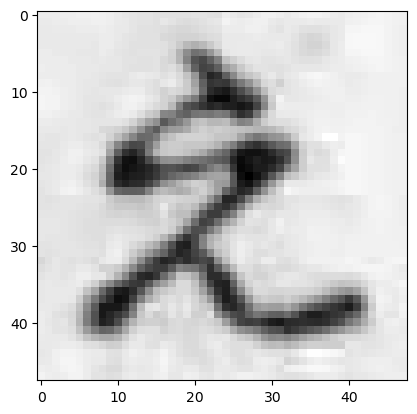

In [87]:
# hiragana
DATADIR = "../data/hiragana73"
CATEGORIES = ["U3042", "U3044", "U3046", "U3048", "U304A"]

category = CATEGORIES[3] # 0: あ, 1: い
path = os.path.join(DATADIR, category)

image_name = os.listdir(path)[0]
img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
print(img_array)
plt.imshow(img_array, cmap="gray")
plt.show()

<AxesSubplot:>

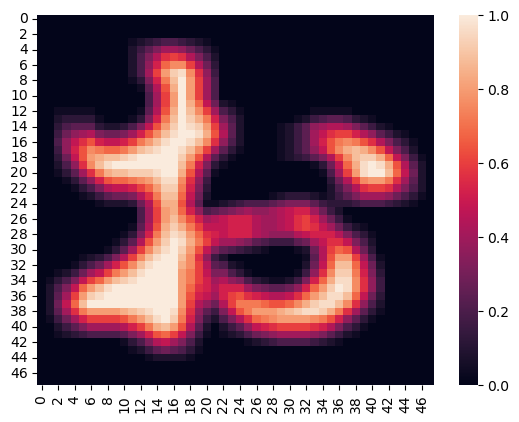

In [122]:
def process_img_test(img):
    img_np = np.array(img)
    img_np = ~img_np
    _, img_th = cv2.threshold(img_np, 0, 1, cv2.THRESH_OTSU)
    kernel = np.ones((5,5),np.float32)/25.
    img_blr = cv2.filter2D(img_th.astype(np.float32),-1,kernel)
    img_blr = img_blr.squeeze()
    return img_blr


# img_np = np.array(img_array)
# img_inv = ~img_np
img_p = process_img_test(img_array)
sns.heatmap(img_p)

In [23]:
def zscore(x, axis = None):
    x_mean = x.mean(axis=axis, keepdims=True)
    x_std  = np.std(x, axis=axis, keepdims=True)
    z_score = (x-x_mean)/x_std
    return z_score

def make_input(img):
    img = np.array(img)
    img = ~img
    img = zscore(img)
    return torch.from_numpy(img).to(torch.float)

In [90]:
test = make_input(img_array)

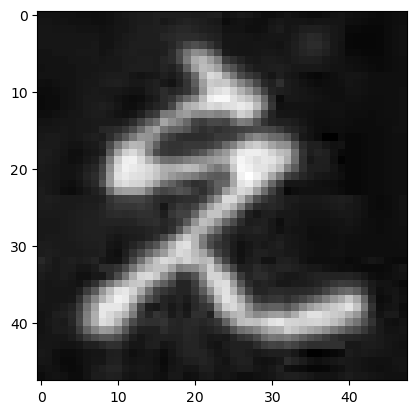

In [91]:
plt.imshow(test, cmap="gray")
plt.show()

In [335]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using: {device}')

using: cpu


In [336]:
img = img_array
n_point = 20
img_size = len(img)

In [337]:
gen = Generator(img_size, n_point).to(device)
disc = Discriminator(img).to(device)

In [338]:
optimizer = optim.SGD(gen.parameters(), lr=0.001)

In [339]:
points_log = []
losses = []

inputs = make_input(img).unsqueeze(0)
inputs = inputs.to(device)

iteration = 2000

gen = gen
disc = disc
gen.train()

for i in range(0, iteration):
    points = gen(inputs)
    points_log.append(points.cpu())
    
    loss = disc(points)
    losses.append(loss.cpu())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if i%100 == 0:
        print(f'iter: {i}, loss: {loss}')

iter: 0, loss: 356.6407775878906
iter: 100, loss: 122.39453887939453
iter: 200, loss: 121.79215240478516
iter: 300, loss: 97.27718353271484
iter: 400, loss: 93.04978942871094
iter: 500, loss: 92.20515441894531
iter: 600, loss: 101.98332214355469
iter: 700, loss: 96.42058563232422
iter: 800, loss: 94.06124877929688
iter: 900, loss: 88.8680191040039
iter: 1000, loss: 91.49785614013672
iter: 1100, loss: 90.95430755615234
iter: 1200, loss: 95.7340087890625
iter: 1300, loss: 92.06367492675781
iter: 1400, loss: 93.85919189453125
iter: 1500, loss: 93.48994445800781
iter: 1600, loss: 95.33385467529297
iter: 1700, loss: 91.97189331054688
iter: 1800, loss: 92.57511901855469
iter: 1900, loss: 86.18190002441406


In [340]:
xy = points_log[-1].squeeze_().detach().numpy()
print(xy.shape)
x = xy[:, 0]
y = xy[:, 1]
print(xy)

(20, 2)
[[18.564684  26.566319 ]
 [21.139824   8.028096 ]
 [ 7.495382  23.83651  ]
 [ 8.063552  24.535048 ]
 [20.396402   8.319709 ]
 [ 7.7214036 25.03419  ]
 [12.5699415 23.693525 ]
 [ 4.3851624 20.31014  ]
 [ 9.933122  27.031359 ]
 [25.554266  23.415936 ]
 [ 9.545282  21.584412 ]
 [ 9.8744135 23.75796  ]
 [19.637438   9.000548 ]
 [21.185423  29.580116 ]
 [15.24834   26.968433 ]
 [18.508684  31.57538  ]
 [41.20741    6.318797 ]
 [28.701992  17.433668 ]
 [43.854977  30.588877 ]
 [11.77917   10.814304 ]]


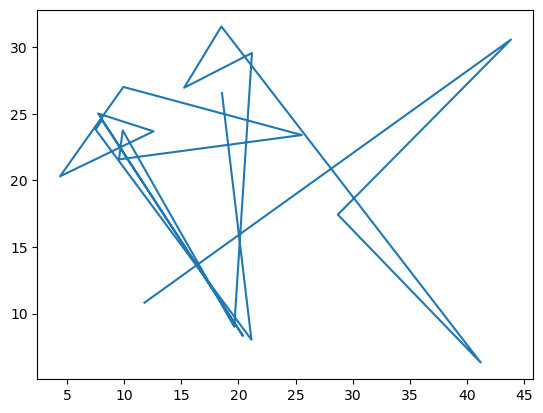

In [341]:
plt.plot(x, y)
plt.show()

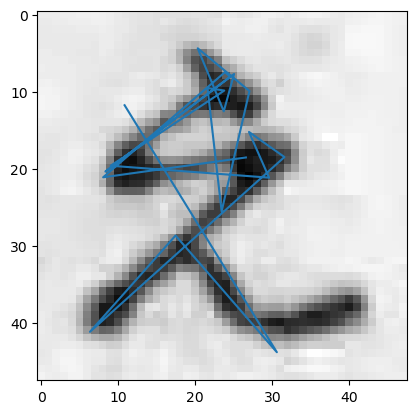

In [342]:
plt.imshow(img_array, cmap="gray")
plt.plot(y, x)
plt.show()

<AxesSubplot:>

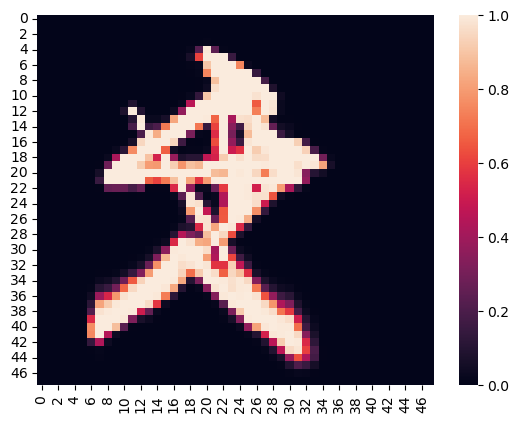

In [343]:
sns.heatmap(disc.p_map.squeeze_().detach().numpy())

<AxesSubplot:>

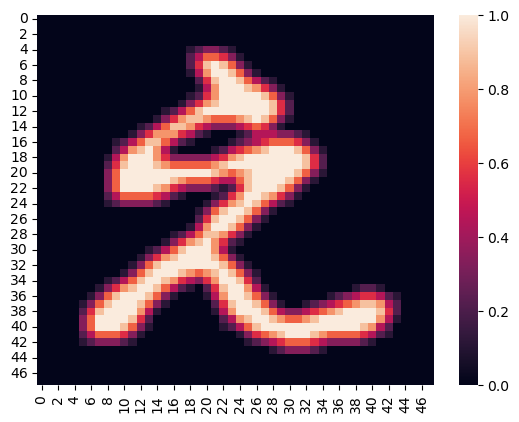

In [344]:
sns.heatmap(disc.img.squeeze_().detach().numpy())

In [345]:
torch.save(gen.state_dict(), 'weight_for_e.pth')

In [346]:
a = torch.tensor([[0.,10.],[100.,1000.]])
torch.tanh(a)

tensor([[0., 1.],
        [1., 1.]])

In [347]:
x = disc.p_map.squeeze_().detach().numpy()
t = disc.img.squeeze_().detach().numpy()

In [348]:
(np.abs(x - t)).sum()/(48*48)

0.07992962996164958

In [349]:
x = disc.p_map
t = disc.img
((x - t)**2).sum()

tensor(90.4464, grad_fn=<SumBackward0>)

In [ ]:
def train_gen1(img, n_point, iteration = 2000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using: {device}')
    
    img_size = len(img)
    
    gen = Generator(img_size, n_point).to(device)
    disc = Discriminator(img).to(device)
    
    optimizer=optim.SGD(gen.parameters(), lr=0.001)
    
    points_log = []
    losses = []

    inputs = make_input(img).unsqueeze(0)
    inputs = inputs.to(device)

    gen = gen.train()

    for i in range(0, iteration):
        points = gen(inputs)
        
        loss = disc(points)
        
        optimizer.zero_grad()
    
        loss.backward()
    
        optimizer.step()
    
        if i%100 == 0:
            print(f'iter: {i}, loss: {loss}')
            points_log.append(points.cpu())
            losses.append(loss.cpu())
            
    return points_log, losses

## 改善

In [3]:
class RoundNoGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.round()
    @staticmethod
    def backward(ctx, g):
        return g

In [4]:
class PlotLine2(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        #self.conv2central = Conv2Central()
#         self.num2point = Num2Point(img_size)
#         self.num2point.load_state_dict(torch.load('params.pth', map_location=torch.device('cpu') ))
#         # freeze all layers
#         for param in self.num2point.parameters():
#             param.requires_grad = False
        self.cs = torch.tensor(range(0, img_size)).to(torch.float).unsqueeze(0)
    
    def forward(self, points):
        N = points.size()[0] # batch_size
        
        points0 = torch.cat((torch.zeros([N,1,2]),
                            points.repeat([1,1,2]).reshape([N,-1, 2]),
                            torch.zeros([N,1,2])), dim=1).reshape([N, -1, 2, 2])[:, 1:-1]
        #print(points0)
        t = torch.tensor(range(0, self.img_size+1))/self.img_size
        ts = torch.stack((1-t, t)).to(torch.float)
        line = torch.matmul(ts.mT, points0)
        #print(line)
        #line = torch.round(line)
        line0 = RoundNoGradient.apply(line)
        #line0 = line
        #print(line0)
        line1 = line0[:, :, 0:-1].reshape(N, -1, 2)
        #print(line1)
        shape = line1.size()
        line2 = line1.flatten()
        #line4 = F.softmax(self.num2point(line2), dim=1)
        line4 = torch.exp(-(line2.reshape(N, -1, 1) - self.cs)**2)
        #print(line4)
        line5 = line4.reshape(*shape, -1)
        x = line5[:, :, 0, :].unsqueeze(2)
        y = line5[:, :, 1, :].unsqueeze(2)
        p_map = torch.matmul(x.mT, y).sum(dim=1)
        #p_map0 = self.conv2central(p_map)
        p_map0 = torch.tanh(p_map)
        #p_map0 = p_map
        return p_map0

tensor([[36., 20.],
        [26., 15.],
        [17., 12.],
        [17., 42.],
        [25., 13.]])
tensor(1., grad_fn=<MaxBackward1>)


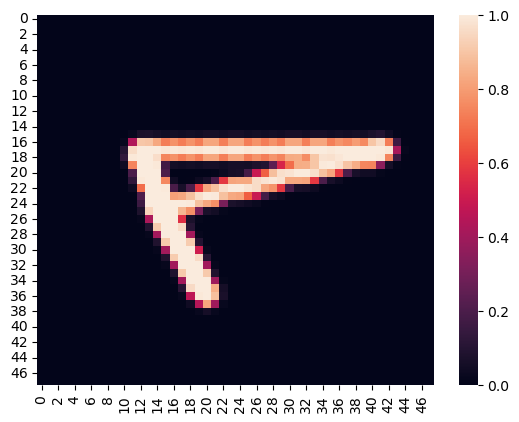

In [5]:
points = torch.randint(0, 48, [5, 2]).to(torch.float)
print(points)
# points = torch.tensor([[ 0.,  0.,  0., 47.,  0., 47.,  0.,  0.,  0., 47.],
#                                         [ 0., 47.,  0., 47.,  0.,  0., 47.,  0., 47.,  0.]])

plot_line2 = PlotLine2(48)
inputs = Variable(points.unsqueeze(0), requires_grad=True)
canvas = plot_line2(inputs)
sns.heatmap(canvas.detach().numpy()[0])
print(canvas.max())

In [6]:
print((torch.diff(points, dim=-2)**2).sum())
print(points[:, 0].var())
print(points.var(dim=-2))
print(points.std(dim=-2))
print(points.mean(dim=-2))
print(points.std(dim=-2)/points.mean(dim=-2))
print((points.var(dim=-2)/(points.mean(dim=-2))**2).sum())

tensor(2020.)
tensor(61.7000)
tensor([ 61.7000, 155.3000])
tensor([ 7.8549, 12.4619])
tensor([24.2000, 20.4000])
tensor([0.3246, 0.6109])
tensor(0.4785)


In [7]:
def process_img2(img):
    img_np = np.array(img)
    img_np = ~img_np
    _, img_th = cv2.threshold(img_np, 0, 1, cv2.THRESH_OTSU)
#     kernel = np.ones((5,5),np.float32)/25.
#     img_blr = cv2.filter2D(img_th.astype(np.float32),-1,kernel)
    # img_blr = img_blr.squeeze()
    return img_th

In [8]:
class Discriminator2(nn.Module):
    def __init__(self, img):
        super().__init__()
        self.img_size = len(img)
        self.img = torch.from_numpy(process_img2(img)).clone().unsqueeze(0)
        
        self.plot_line = PlotLine2(self.img_size)
        #self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        self.p_map = None
        
    def forward(self, points):
        alpha = 0.06 #0.06
        beta = 1.75 #1.00
        distance = (torch.diff(points, dim=-2)**2).sum()
        step_distances = (torch.diff(points, dim=-2)**2).sum(dim=-1)
        step_mean = step_distances.mean()
#         var = points.var(dim=-2).sum()
        var = points.std(dim=-2).sum()
#         var = torch.log(points.var(dim=-2).sum())
#         var = 1.
        eps = 1e-5
        const = distance/(var + eps)
        
        x = self.plot_line(points)
        self.p_map = x
        t = self.img
        #loss = torch.sum(x*self.img)
        #loss = self.criterion(x, self.img)
        #loss = ((x - t)**2).sum() + distance
        #loss = ((x - t)**2).sum() + const
        loss = (beta*((x - t)**2).sum() + alpha*distance)/(var + eps)
#         loss = (beta*((x - t)**2).sum())/(var + eps) + alpha*distance
        return loss

In [9]:
torch.tanh(torch.tensor([0.1,1,5,10,100]))

tensor([0.0997, 0.7616, 0.9999, 1.0000, 1.0000])

In [10]:
class Generator2(nn.Module):
    def __init__(self, img_size, n_point):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        output_size = 2*n_point
        hidden_size1 = img_size*output_size
        hidden_size2 = n_point**2
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=False)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=False)
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, img):
        x = self.flatten(img)
        #x = x.view(-1, 1) # Linear層に入力できるようにサイズを(batch_size, C)にする. --> x = nn.Flatten(img)
        x = self.sigmoid(self.fc1(x)) # write me! # fc1 + sigmoid
        x = self.sigmoid(self.fc2(x)) # write me! # fc2 + sigmoid
        y = self.fc3(x) # write me! # fc3
        y_num = torch.sigmoid(y)*float(self.img_size - 1.0)
        out = y_num.reshape(-1, self.n_point, 2)
        return out

In [11]:
def zscore(x, axis = None):
    x_mean = x.mean(axis=axis, keepdims=True)
    x_std  = np.std(x, axis=axis, keepdims=True)
    z_score = (x-x_mean)/x_std
    return z_score

def make_input(img):
    img = np.array(img)
    img = ~img
    img = zscore(img)
    return torch.from_numpy(img).to(torch.float)

In [12]:
def train_gen2(img, n_point=20, iteration = 2000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using: {device}')
    
    img_size = len(img)
    
    gen = Generator2(img_size, n_point).to(device)
    disc = Discriminator2(img).to(device)
    
    optimizer=optim.SGD(gen.parameters(), lr=0.001)
    
    points_log = []
    losses = []

    inputs = make_input(img).unsqueeze(0)
    inputs = inputs.to(device)

    gen = gen.train()

    for i in range(0, iteration):
        points = gen(inputs)
        
        loss = disc(points)
        
        optimizer.zero_grad()
    
        loss.backward()
    
        optimizer.step()
    
        if i%100 == 0:
            print(f'iter: {i}, loss: {loss}')
            points_log.append(points.cpu())
            losses.append(loss.cpu())
            
    return points_log, losses

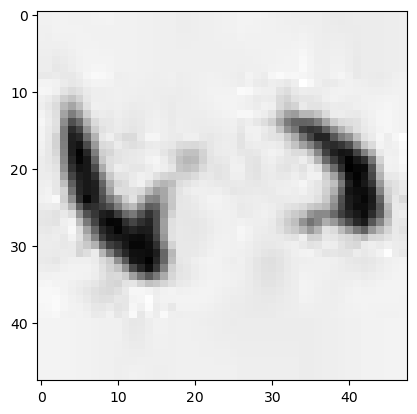

In [13]:
# hiragana
DATADIR = "../data/hiragana73"
CATEGORIES = ["U3042", "U3044", "U3046", "U3048", "U304A"]

category = CATEGORIES[1] # 0: あ, 1: い
path = os.path.join(DATADIR, category)

image_name = os.listdir(path)[0]
img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
#print(img_array)
plt.imshow(img_array, cmap="gray")
plt.show()

In [18]:
points_log, losses = train_gen2(img_array, n_point=10)

using: cpu
iter: 0, loss: 83.38285064697266
iter: 100, loss: 17.024972915649414
iter: 200, loss: 16.315942764282227
iter: 300, loss: 16.320068359375
iter: 400, loss: 17.02876091003418
iter: 500, loss: 16.567602157592773
iter: 600, loss: 12.093910217285156
iter: 700, loss: 11.638171195983887
iter: 800, loss: 11.539993286132812
iter: 900, loss: 11.523893356323242
iter: 1000, loss: 11.304925918579102
iter: 1100, loss: 11.5315523147583
iter: 1200, loss: 11.073185920715332
iter: 1300, loss: 11.155953407287598
iter: 1400, loss: 11.169434547424316
iter: 1500, loss: 11.1933012008667
iter: 1600, loss: 11.126209259033203
iter: 1700, loss: 11.076848983764648
iter: 1800, loss: 11.068282127380371
iter: 1900, loss: 11.161452293395996


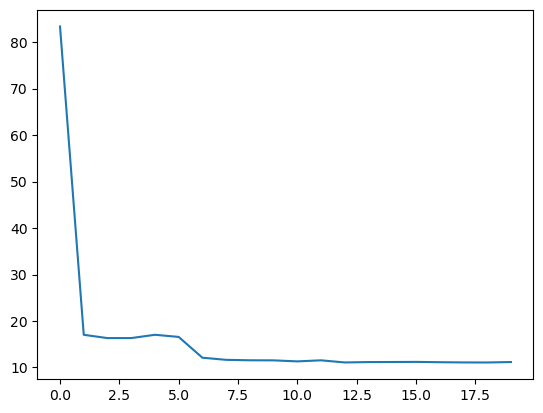

In [19]:
plt.plot([loss.detach().numpy() for loss in losses])

<AxesSubplot: >

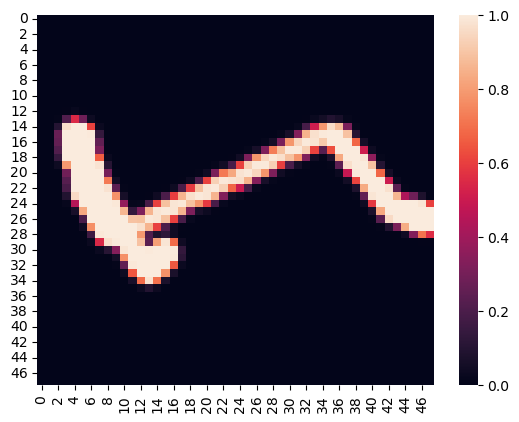

In [20]:
plot_line2 = PlotLine2(48)
canvas = plot_line2(points_log[-1])
sns.heatmap(canvas.detach().numpy()[0])

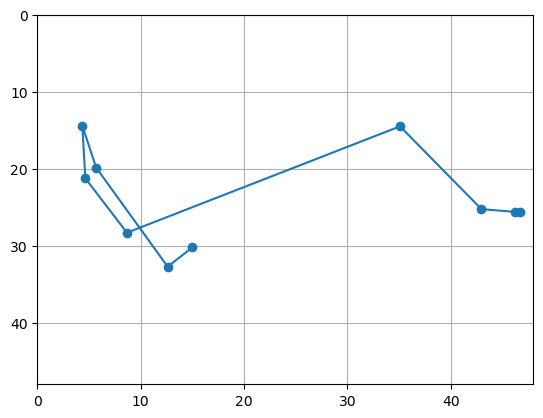

In [21]:
pos = points_log[-1].detach().numpy().squeeze()

fig, ax = plt.subplots(1,1)
ax.set_xlim(0, 48)
ax.set_ylim(0, 48)
ax.invert_yaxis()
ax.grid()
ax.plot(pos[:, 1], pos[:, 0], marker='o')
plt.show()

In [226]:
pos.shape

(20, 2)

In [72]:
def Bresenham(p0, p1):
    line = []
    x0, y0 = p0
    x1, y1 = p1
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = np.sign(x1 - x0)
    sy = np.sign(y1 - y0)
    err = dx - dy
    while x0 != x1 or y0 != y1 :
        line.append((x0, y0))
        e2 = 2*err
        if e2 > -dy:
            err -= dy
            x0 += sx
        
        if e2 < dx:
            err += dx
            y0 += sy
    return line

def Bresenham_line(data, p0, p1, value=255):
    line = Bresenham(p0, p1)
    for p in line:
        data[p] = value

def Bresenham_plot(data, points):
    for i in  range(len(points)-1):
        p0 = points[i]
        p1 = points[i+1]
        Bresenham_line(data, p0, p1, value=255)
    return data

In [75]:
#pos = points_log[-1].detach().numpy().squeeze()
points = np.random.randint(0, 48, [5, 2])

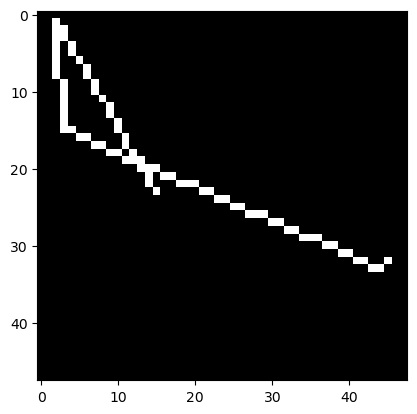

In [78]:
data = np.zeros([48, 48])
data = Bresenham_plot(data, points)
plt.imshow(data, cmap="gray")
plt.show()

In [3]:
a = np.array([1,2])
a1, a2 = a

In [4]:
a1

1

In [5]:
a2

2